# Weapon detection

In [16]:
#importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import kagglehub
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.utils.class_weight import compute_class_weight
import sys
from PIL import Image
import os

In [4]:
#download data from kaggle do it only once
path = kagglehub.dataset_download("snehilsanyal/weapon-detection-test")
path
#path = '/Users/bahacelik/.cache/kagglehub/datasets/snehilsanyal/weapon-detection-test/versions/5'

100%|██████████| 194M/194M [00:01<00:00, 167MB/s]

Extracting files...


'/root/.cache/kagglehub/datasets/snehilsanyal/weapon-detection-test/versions/5'

In [5]:
df_metadata = pd.read_csv(path+'/metadata.csv')
path_train_images = path+'/weapon_detection/train/images'
path_train_labels = path+'/weapon_detection/train/labels'
path_val_images = path+'/weapon_detection/val/images'
path_val_labels = path+'/weapon_detection/val/labels'

In [6]:
df_metadata.head()

,imagefile,labelfile,target,train_id
0,Automatic Rifle_10.jpeg,Automatic Rifle_10.txt,0,1
1,Automatic Rifle_100.jpeg,Automatic Rifle_100.txt,0,1
2,Automatic Rifle_11.jpeg,Automatic Rifle_11.txt,0,1
3,Automatic Rifle_12.jpeg,Automatic Rifle_12.txt,0,1
4,Automatic Rifle_13.jpeg,Automatic Rifle_13.txt,0,0


In [7]:
df_metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 714 entries, 0 to 713
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   imagefile  714 non-null    object
 1   labelfile  714 non-null    object
 2   target     714 non-null    int64 
 3   train_id   714 non-null    int64 
dtypes: int64(2), object(2)
memory usage: 22.4+ KB


In [17]:
#convert data type of the column to str
df_metadata['target'] = df_metadata['target'].astype('str')

#get the number of classes
NUM_CLASSES = df_metadata['target'].nunique()

#copy the data
train_df = df_metadata[df_metadata['train_id'] == 1].copy()
val_df = df_metadata[df_metadata['train_id'] == 0].copy()

class_weights = compute_class_weight('balanced', classes=np.unique(train_df['target']), y=train_df['target'])
class_weights_dict = dict(enumerate(class_weights))

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Model: "WeaponClassifierCNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1_1 (Conv2D)                │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_2 (Conv2D)                │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2_1 (Conv2D)                │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2_2 (Conv2D)                │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3_1 (Conv2D)                │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3_2 (Conv2D)                │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool3 (MaxPooling2D)            │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 256)            │    16,777,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout1 (Dropout)              │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense2 (Dense)                  │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout2 (Dropout)              │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,997,961 (64.84 MB)

 Trainable params: 16,997,961 (64.84 MB)

 Non-trainable params: 0 (0.00 B)

Loading training images from: /root/.cache/kagglehub/datasets/snehilsanyal/weapon-detection-test/versions/5/weapon_detection/train/images
Found 571 validated image filenames belonging to 9 classes.
Loading validation images from: /root/.cache/kagglehub/datasets/snehilsanyal/weapon-detection-test/versions/5/weapon_detection/val/images
Found 143 validated image filenames belonging to 9 classes.

--- Starting Model Training ---


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 33s 807ms/step - accuracy: 0.1162 - loss: 2.2977 - val_accuracy: 0.1016 - val_loss: 2.1975 - learning_rate: 0.0010
Epoch 2/50
 1/35 ━━━━━━━━━━━━━━━━━━━━ 5s 162ms/step - accuracy: 0.0625 - loss: 2.3382

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - accuracy: 0.0625 - loss: 2.3382 - val_accuracy: 0.1016 - val_loss: 2.1974 - learning_rate: 0.0010
Epoch 3/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 40s 942ms/step - accuracy: 0.1189 - loss: 2.1839 - val_accuracy: 0.1016 - val_loss: 2.1976 - learning_rate: 0.0010
Epoch 4/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - accuracy: 0.0625 - loss: 2.1794 - val_accuracy: 0.1016 - val_loss: 2.1976 - learning_rate: 0.0010
Epoch 5/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.1205 - loss: 2.1888 - val_accuracy: 0.1484 - val_loss: 2.1993 - learning_rate: 0.0010
Epoch 6/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 0.0625 - loss: 2.2225 - val_accuracy: 0.1094 - val_loss: 2.1976 - learning_rate: 0.0010
Epoch 7/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.1272 - loss: 2.2077 - val_accuracy: 0.1328 - val_loss: 2.1981 - learning_rate: 0.0010
Epoch 8/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step - accuracy: 0.0625 - loss: 2.1234 - val_accuracy: 0.13

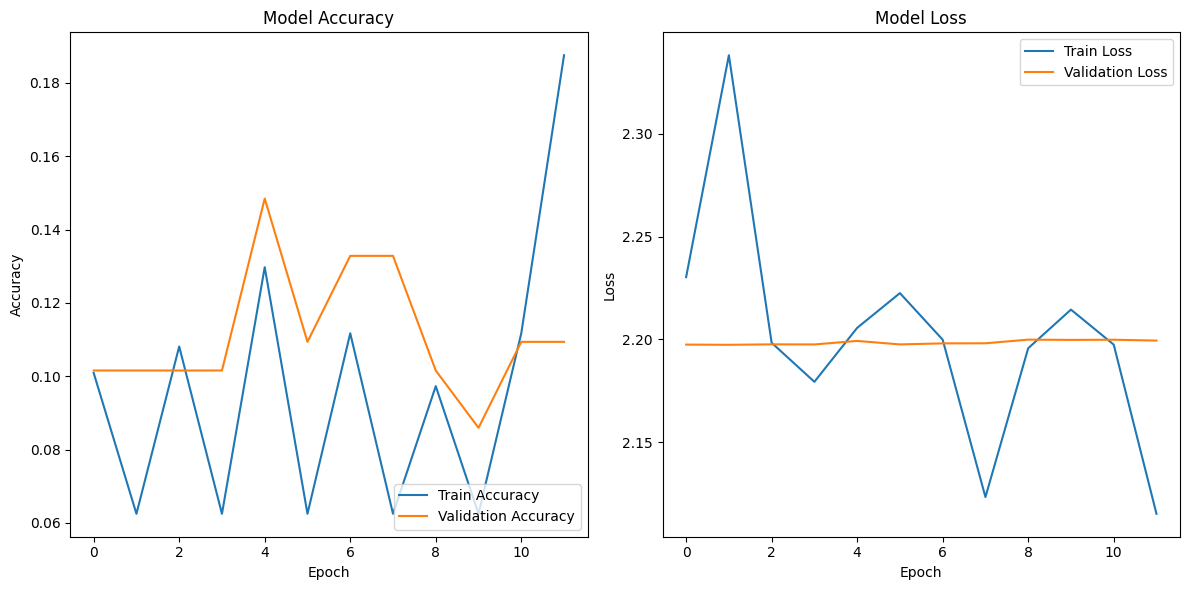

In [20]:
# --- Image and Training Configuration ---
IMG_HEIGHT = 256
IMG_WIDTH = 256
CHANNELS = 3      # 3 for RGB, 1 for grayscale
LEARNING_RATE = 0.001
BATCH_SIZE = 16
EPOCHS = 50

def build_custom_cnn(input_shape, num_classes):
    model = Sequential(name="WeaponClassifierCNN")
    model.add(Input(shape=input_shape, name="input_layer"))

    # Block 1
    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same', name="conv1_1"))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same', name="conv1_2"))
    model.add(MaxPooling2D(pool_size=(2, 2), name="pool1"))

    # Block 2
    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same', name="conv2_1"))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same', name="conv2_2"))
    model.add(MaxPooling2D(pool_size=(2, 2), name="pool2"))

    # Block 3
    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same', name="conv3_1"))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same', name="conv3_2"))
    model.add(MaxPooling2D(pool_size=(2, 2), name="pool3"))

    model.add(Flatten(name="flatten"))
    model.add(Dense(units=256, activation='relu', name="dense1"))
    model.add(Dropout(rate=0.5, name="dropout1"))
    model.add(Dense(units=128, activation='relu', name="dense2"))
    model.add(Dropout(rate=0.3, name="dropout2"))
    model.add(Dense(units=num_classes, activation='softmax', name="output_layer"))

    optimizer = Adam(learning_rate=LEARNING_RATE)
    model.compile(optimizer=optimizer,
                  loss=CategoricalCrossentropy(),
                  metrics=['accuracy'])
    return model

# --- Create Model ---
input_shape = (IMG_HEIGHT, IMG_WIDTH, CHANNELS)
model = build_custom_cnn(input_shape, NUM_CLASSES)
model.summary()

# --- Data Augmentation and Loading ---
# Note: The .txt label files (YOLO format) are for object detection.
# For this classification task, we are using the 'target' column from metadata.csv as the class label.

# Training data generator with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,            # Normalize pixel values to [0, 1]
    rotation_range=30,         # Randomly rotate images by up to 30 degrees
    width_shift_range=0.2,     # Randomly shift images horizontally by up to 20% of width
    height_shift_range=0.2,    # Randomly shift images vertically by up to 20% of height
    shear_range=0.2,           # Apply shear transformations
    zoom_range=0.2,            # Randomly zoom into images
    horizontal_flip=True,      # Randomly flip images horizontally
    fill_mode='nearest',        # Strategy for filling newly created pixels
    brightness_range=[0.8, 1.2]
)

# Validation data generator (only rescaling, no augmentation)
validation_datagen = ImageDataGenerator(rescale=1./255)

# Flow data from DataFrame
print(f"Loading training images from: {path_train_images}")
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=path_train_images, # Path to the directory for training images
    x_col='imagefile',               # Column in dataframe with image file names
    y_col='target',                  # Column in dataframe with class labels
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',        # For multi-class classification with one-hot encoded labels
    shuffle=True
)

print(f"Loading validation images from: {path_val_images}")
validation_generator = validation_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=path_val_images, # Path to the directory for validation images
    x_col='imagefile',
    y_col='target',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False # No need to shuffle validation data
)

# Check if generators found images
if train_generator.samples == 0:
    print("ERROR: No training images found by the ImageDataGenerator. Check paths and 'imagefile' column.")
    sys.exit(1)
if validation_generator.samples == 0:
    print("ERROR: No validation images found by the ImageDataGenerator. Check paths and 'imagefile' column.")
    sys.exit(1)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)
early_stopper = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    restore_best_weights=True
)

# --- Train the Model ---
print(f"\n--- Starting Model Training ---")
history = model.fit(
    train_generator,
    steps_per_epoch=max(1, train_generator.samples // BATCH_SIZE), # Ensure at least 1 step
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=max(1, validation_generator.samples // BATCH_SIZE), # Ensure at least 1 step
    callbacks=[reduce_lr, early_stopper],
    class_weight=class_weights_dict
  )

print("\n--- Training Complete ---")

# --- Evaluate the Model (Optional: on a separate test set if available) ---
# For now, we'll just print validation accuracy from the last epoch.
# val_loss, val_accuracy = model.evaluate(validation_generator, steps=validation_generator.samples // BATCH_SIZE)
# print(f"Final Validation Accuracy: {val_accuracy*100:.2f}%")
# print(f"Final Validation Loss: {val_loss:.4f}")

# --- Visualize Training History ---
if history is not None:
    plt.figure(figsize=(12, 6))

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()
